In [198]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
%matplotlib inline

def normalize(img):
    for c in range(img.shape[2]):
        max = 0
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if max < img[i][j][c]:
                    max = img[i][j][c]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                img[i][j][c] = np.uint8(round(img[i][j][c] / max * 255))
    return img

def detector_max(himg):
    size = himg.shape[0]
    channels = himg.shape[2]
    max = 0
    a = 0
    maxx = 0
    maxy = 0
    for i in range(size):
        for j in range(size):
            a = 0
            for c in range(channels):
                a += himg[i][j][c]
            if (a > max):
                max = a
                maxx = i
                maxy= j
    return maxx, maxy

def detector_min(himg):
    size = himg.shape[0]
    channels = himg.shape[2]
    min = 255 * 3
    a = 0
    minx = 0
    miny = 0
    for i in range(size):
        for j in range(size):
            a = 0
            for c in range(channels):
                a += himg[i][j][c]
            if (a < min):
                min = a
                minx = i
                miny= j
                n = 0
            #print("!!!", i, j, himg[i][j])
    return minx, miny

def FHT_vert_r(img):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    hough_Img = np.array([ [ [0] * channels for i in range(length)] for j in range(height)])
    if(length == 1):
        return img
    left = []
    right = []
    for i in range(height):
        left.append(img[i][:(length // 2)])
        right.append(img[i][(length // 2):])
    left = FHT_vert_r(np.array(left))
    right = FHT_vert_r(np.array(right))
    for ch in range(channels):
        for i in range(0, length, 2):
            shift = i // 2
            for j in range(height):
                index = (j + shift) % height
                hough_Img[j][i][ch] = int(left[j][i // 2][ch]) + int(right[index][i // 2][ch])
                index = (j + shift + 1) % height
                hough_Img[j][i + 1][ch] = int(left[j][i // 2][ch]) + int(right[index][i // 2][ch])
    return hough_Img

def FHT_vert_l(img):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    hough_Img = np.array([ [ [0] * channels for i in range(length)] for j in range(height)])
    if(length == 1):
        return img
    left = []
    right = []
    for i in range(height):
        left.append(img[i][:(length // 2)])
        right.append(img[i][(length // 2):])
    left = FHT_vert_l(np.array(left))
    right = FHT_vert_l(np.array(right))
    for ch in range(channels):
        for i in range(0, length, 2):
            shift = i // 2
            for j in range(height):
                index = (j - shift) % height
                hough_Img[j][i][ch] = int(left[j][i // 2][ch]) + int(right[index][i // 2][ch])
                index = (j - shift - 1) % height
                hough_Img[j][i + 1][ch] = int(left[j][i // 2][ch]) + int(right[index][i // 2][ch])
    return hough_Img

def FHT_horiz_dwn(img):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    hough_Img = np.array([ [ [0] * channels for i in range(length)] for j in range(height)])
    if(height == 1):
        return img
    up = img[:(height // 2)]
    down = img[(height // 2):]
    up = FHT_horiz_dwn(np.array(up))
    down = FHT_horiz_dwn(np.array(down))
    for ch in range(channels):
        for i in range(0, height, 2):
            shift = i // 2
            for j in range(length):
                index = (j - shift) % length
                hough_Img[i][j][ch] = int(up[i // 2][j][ch]) + int(down[i // 2][index][ch])
                index = (j - shift - 1) % length
                hough_Img[i + 1][j][ch] = int(up[i // 2][j][ch]) + int(down[i // 2][index][ch])
    return hough_Img

def FHT_horiz_up(img):
    height = img.shape[0]
    length = img.shape[1]
    channels = img.shape[2]
    
    hough_Img = np.array([ [ [0] * channels for i in range(length)] for j in range(height)])
    if(height == 1):
        return img
    up = img[:(height // 2)]
    down = img[(height // 2):]
    up = FHT_horiz_up(np.array(up))
    down = FHT_horiz_up(np.array(down))
    for ch in range(channels):
        for i in range(0, height, 2):
            shift = i // 2
            for j in range(length):
                index = (j + shift) % length
                hough_Img[i][j][ch] = int(up[i // 2][j][ch]) + int(down[i // 2][index][ch])
                index = (j + shift + 1) % length
                hough_Img[i + 1][j][ch] = int(up[i // 2][j][ch]) + int(down[i // 2][index][ch])
    return hough_Img

def rd(n):
    if((n - int(n)) >= 0.5):
        return (int(n)+1)
    else:
        return int(n)

from math import log2
    
def draw_horiz_up(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for x in range(img.shape[0]):
        y = 0
        for k in range(len(t_bytes)):
            y += t_bytes[k] * rd(2 ** k * x/ (img.shape[0] - 1))
        y += s
        y = y % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

def draw_horiz_dwn(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for x in range(img.shape[0]):
        y = 0
        for k in range(len(t_bytes)):
            y -= t_bytes[k] * rd(2 ** k * x/ (img.shape[0] - 1))
        y += s
        y = y % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

def draw_vert_r(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for y in range(img.shape[0]):
        x = 0
        for k in range(len(t_bytes)):
            x += t_bytes[k] * rd(2 ** k * y/ (img.shape[0] - 1))
        x += s
        x = x % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

def draw_vert_l(img, s, t, color):
    p = int(log2(img.shape[0]))
    t_bytes = np.zeros(p, dtype=int)
    for i in range(p):
        t_bytes[i] = t % 2
        t = t // 2
    for y in range(img.shape[0]):
        x = 0
        for k in range(len(t_bytes)):
            x -= t_bytes[k] * rd(2 ** k * y/ (img.shape[0] - 1))
        x += s
        x = x % img.shape[0]
        img[x][y] = np.uint8(color)
    return img

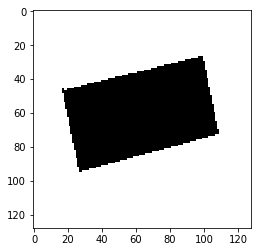

In [199]:
img = cv.imread("./img/qqq.png")
plt.imshow(img)

(41, 36)
[255 255 255]


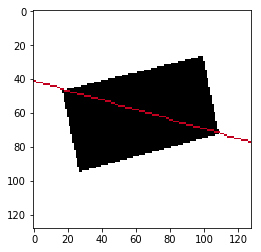

In [200]:
import copy
himg1 = normalize(FHT_vert_r(img))
line = detector_min(himg1)
print(line)
canvas = copy.deepcopy(img)
#canvas = np.zeros((128,128,3))
canvas = draw_vert_r(canvas, line[0], line[1], (193, 0, 32))
plt.imshow(canvas)
print(himg1[0][0])

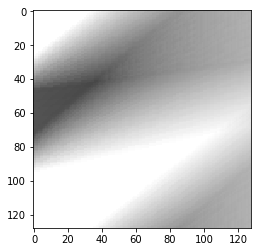

In [201]:
plt.imshow(himg1)

(47, 0)


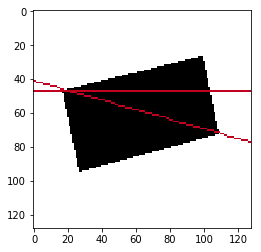

In [202]:
himg2 = normalize(FHT_vert_l(img))
line = detector_min(himg2)
print(line)
canvas = draw_vert_l(canvas, line[0], line[1], (193, 0, 32))
plt.imshow(canvas)

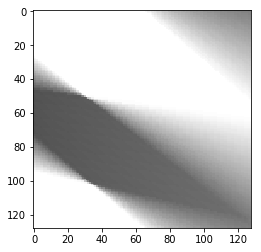

In [203]:
plt.imshow(himg2)

(0, 28)


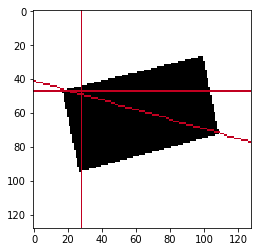

In [204]:
himg3 = normalize(FHT_horiz_up(img))
line = detector_min(himg3)
print(line)
canvas = draw_horiz_up(canvas, line[1], line[0], (193, 0, 32))
plt.imshow(canvas)

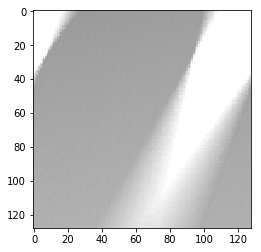

In [205]:
plt.imshow(himg3)

(125, 121)


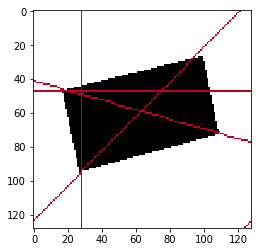

In [206]:
himg4= normalize(FHT_horiz_dwn(img))
line = detector_min(himg4)
print(line)
canvas = draw_horiz_dwn(canvas, line[1], line[0], (193, 0, 32))
plt.imshow(canvas)

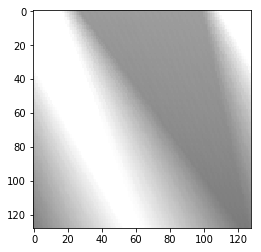

In [207]:
plt.imshow(himg4)